# Xây dựng và Huấn luyện Mô hình Dự đoán Điểm Rating
Trong phần này, nhóm tiến hành xây dựng các mô hình học máy để dự đoán điểm rating của phim dựa trên các đặc trưng đã được tiền xử lý tập trung vào thuật toán **Random Forest Regressor**.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

### 1. Tải dữ liệu đã tiền xử lý
Nhóm thực hiện load dữ liệu từ thư mục `processed`. Dữ liệu này đã được làm sạch, xử lý giá trị thiếu, mã hóa các biến phân loại và chuẩn hóa các biến số trong file `data_exploration` trước đó.

In [2]:
# Xác định đường dẫn file
processed_path = '../data/processed'
train_file = f'{processed_path}/train_processed.csv'
test_file = f'{processed_path}/test_processed.csv'

# Load dữ liệu từ CSV
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

Nhóm thực hiện đọc các file CSV và tách biến mục tiêu `rating` ra khỏi các đặc trưng đầu vào.

In [3]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

target_col = 'rating'
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

Kiểm tra nhanh kích thước dữ liệu train và test 1 lần nữa trước khi xây dựng mô hình học máy.

In [4]:
print(f"Train set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set:  {X_test.shape[0]} samples, {X_test.shape[1]} features")

Train set: 7708 samples, 45 features
Test set:  1928 samples, 45 features


### 2. Đánh giá mô hình Random Forest bằng K-Fold Cross-Validation
Thông thường, khi chia dữ liệu theo tỷ lệ cố định (ví dụ 80% Train và 20% Test), nhóm nhận định kết quả đánh giá có thể bị ảnh hưởng bởi yếu tố may rủi. Cụ thể là nếu tập Test vô tình chứa toàn những dữ liệu dễ đoán, kết quả sẽ cao bất thường và ngược lại.

Vì vậy, nhóm đề xuất dùng kĩ thuật K-Fold Cross-Validation để giải quyết vấn đề này bằng cách chia dữ liệu thành $K$ phần (trong phạm vi của bài toán này thì nhóm chọn $K=5$). Cơ chế hoạt động của 5-Fold Cross-Validation như sau:
- Chia dữ liệu: Tập dữ liệu huấn luyện được xáo trộn ngẫu nhiên và chia thành 5 phần (folds) bằng nhau.
- Xây dựng quá trình huấn luyện thông qua 5 lần độc lập:
  + Lần 1: Dùng fold 1 làm tập kiểm chứng (Validation), 4 fold còn lại để huấn luyện.
  + Lần 2: Dùng fold 2 làm tập kiểm chứng, các fold còn lại để huấn luyện, và cứ thế lặp lại cho đến hết 5 fold.
- Tổng hợp kết quả: Sau 5 lần, nhóm sẽ thu được 5 giá trị $R^2$ và RMSE khác nhau. Giá trị trung bình của chúng chính là con số đại diện cho năng lực thực sự của mô hình.

Ở phần này, nhóm tập trung thực hiện đánh giá mô hình với các tham số mặc định của thư viện scikit-learn. Lí do cho việc đánh giá bước đầu bằng các tham số mặc định là vì:
- Thiết lập Baseline để thể hiện tính nguyên bản của Random Forest vì ở đây chưa can thiệp vào việc tinh chỉnh các tham số. 
- Kiểm tra độ ổn định bằng cách nhìn vào độ lệch chuẩn hoặc phương sai qua các vòng lặp. Nếu độ lệch chuẩn thấp, nghĩa là mô hình hoạt động ổn định trên mọi phân khúc dữ liệu (phim cũ, phim mới, phim bom tấn hay độc lập).
- Ngoài ra, nếu kết quả Cross-Validation ban đầu đã tốt, nhóm sẽ có cơ sở vững chắc để thực hiện các bước tối ưu hóa chuyên sâu hơn ở giai đoạn sau.

Tóm lại, việc áp dụng K-Fold giúp nhóm khẳng định rằng các kết quả sau khi dự đoán không phải nhờ sự may rủi trong việc chia dữ liệu, mà đến từ năng lực thực tế của thuật toán đã được kiểm chứng qua toàn bộ các góc độ của tập dữ liệu huấn luyện.

In [5]:
# Khởi tạo mô hình và K-Fold (K=5)
rf_default = RandomForestRegressor(random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Thực hiện Cross-Validation
cv_results = cross_validate(
    rf_default, X_train, y_train, 
    cv=kf, 
    scoring=['neg_root_mean_squared_error', 'r2'],
    n_jobs=-1
)

r2_scores = cv_results['test_r2']
rmse_scores = -cv_results['test_neg_root_mean_squared_error']

r2_std = np.std(r2_scores)
rmse_std = np.std(rmse_scores)
r2_mean = np.mean(r2_scores)
rmse_mean = np.mean(r2_scores)

print(f"R^2: {r2_scores.mean():.4f} (+/- {r2_scores.std():.4f})")
print(f"RMSE: {rmse_scores.mean():.4f} (+/- {rmse_scores.std():.4f})")

R^2: 0.5942 (+/- 0.0219)
RMSE: 0.6083 (+/- 0.0135)


Nhìn vào kết quả, với chỉ số $R^2 \approx 0.594$ cho thấy mô hình giải thích được gần 60% sự biến thiên của điểm rating phim. Trong các bài toán dự đoán hành vi hoặc đánh giá nghệ thuật (vốn mang tính cảm tính cao và chịu ảnh hưởng của nhiều yếu tố ngẫu nhiên), con số $R^2 > 0.5$ được coi là rất khả quan. Còn với chỉ số $RMSE \approx 0.61$ trên thang điểm 10, điều này có nghĩa là dự đoán của mô hình thường chỉ lệch quanh mức 0.6 điểm so với thực tế — một con số rất ấn tượng, cho thấy mô hình hiểu khá rõ cách khán giả chấm điểm phim.

Ngoài ra, xét ở tính ổn định cho việc áp dụng kĩ thuật K-Fold Cross-Validation thì nhóm nhận thấy độ lệch chuẩn của $R^2$ cực thấp ($0.0219$). Có thể thấy con số này duới 0.05 và tỷ lệ biến động của nó chỉ chiếm khoảng 3.7% so với giá trị trung bình ($0.0219 / 0.5942$). Độ lệch chuẩn của $RMSE$ cũng cực thấp ($0.0135$) và tỷ lệ biến động của nó cũng chỉ chiếm khoảng 2.2% ($0.0135 / 0.6083$). Từ đó nhóm kết luận rằng mô hình cực kỳ ổn định với kĩ thuật này và rất phù hợp để qua giai đoạn tinh chỉnh các tham số. 

### 3. Tinh chỉnh tham số (Fine-tuning) với GridSearchCV
Để tìm ra bộ tham số tối ưu nhất cho mô hình Random Forest, nhóm sử dụng **GridSearchCV**. Quy trình này sẽ thử nghiệm các tổ hợp khác nhau của các tham số như độ sâu của cây (`max_depth`), số lượng cây (`n_estimators`), và số mẫu tối thiểu để chia nhánh (`min_samples_split`).

Đầu tiên là khởi tạo mô hình

In [6]:
rf = RandomForestRegressor(random_state=42)

Nhóm thiết lập lưới tham số như bên dưới, với ý nghĩa từng tham số như sau:
- `n_estimators` là số lượng cây quyết định. Càng nhiều cây, mô hình càng ổn định và dự đoán chính xác hơn vì các sai số của từng cây đơn lẻ sẽ được triệt tiêu khi lấy trung bình. Vì nếu số lượng cây quá lớn (ví dụ > 300) thì thời gian huấn luyện sẽ tăng rất lâu mà hiệu quả cải thiện không đáng kể, cho nên nhóm chỉ thiết lập số lượng cây ở các mức 20, 50, 100, 200, 300. 
- `max_depth` quy định chiều dài tối đa từ gốc đến lá của một cây. Ở đây `max_depth` ở các mức 10, 20 và None. 
- `min_samples_split` là số mẫu tối thiểu để chia nhánh. Ý nghĩa của nó là một node trong cây chỉ được phép chia tiếp nếu nó chứa ít nhất số lượng mẫu quy định. Con số này càng lớn thì mô hình càng chặt chẽ và ngăn chặn việc tạo ra các nhánh quá nhỏ lẻ. Đây còn là một công cụ cực kỳ hiệu quả để chống Overfitting. Ở đây, các giá trị 2, 5, 10 được thiết lập giúp nhóm tìm ra điểm cân bằng giữa việc học chi tiết và tính tổng quát hóa.
- `max_features` là số lượng đặc trưng tối đa cân nhắc mỗi lần chia. Việc thiết lập sqrt hoặc log2 giúp các cây trong rừng trở nên khác biệt nhau, làm tăng tính đa dạng và độ chính xác của cả hệ thống. Còn None thì sẽ cân nhắc tất cả các đặc trưng, giống với mô hình Bagging truyền thống.

In [7]:
param_grid = {
    'n_estimators': [20, 50, 100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

Kĩ thuật GridSearchCV mà nhóm áp dụng hoạt động dựa trên cơ chế  brute-force:
- Đầu tiên là tạo luới (grid) qua việc thiết lập một danh sách các giá trị tiềm năng cho từng tham số như ở bước trên.
- Từ đó thì GridSearchCV sẽ tạo ra tất cả các tổ hợp có thể có từ danh sách này. Với lưới tham số của nhóm, tổng số tổ hợp sẽ là: $5  \times 3 \times 3 \times 3 \text = 135$ tổ hợp.
- Sau đó là bước huấn luyện và kiểm chứng chéo. Với mỗi tổ hợp, GridSearchCV sẽ thực hiện 5-Fold Cross-Validation, tức là chạy $135 \times 5 = 675$ lần huấn luyện để đảm bảo bộ tham số tìm được thực sự tối ưu trên mọi phần dữ liệu.
- Cuối cùng là lựa chọn ra bộ tham số có điểm $R^2$ trung bình cao nhất qua các vòng kiểm chứng để được chọn làm mô hình cuối cùng.

In [8]:
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5, 
    scoring='r2', 
    n_jobs=-1, 
    verbose=2 
)

Bắt đầu quá trình tìm kiếm bộ tham số tốt nhất

In [9]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [20, 50, 100, 200, 300]},
             scoring='r2', verbose=2)

Bộ tham số tốt nhất mà nhóm thu được như sau

In [10]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best CV R^2 Score: {best_score:.4f}")

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}
Best CV R^2 Score: 0.5982


### 4. Huấn luyện mô hình tối ưu và Đánh giá Benchmark
Sau khi tìm được bộ tham số tốt nhất, nhóm sử dụng mô hình đó để dự đoán trên tập dữ liệu **Test** (dữ liệu mô hình chưa từng thấy trong quá trình học) để đưa ra kết quả Benchmark cuối cùng. 

In [12]:
best_model = grid_search.best_estimator_
y_pred_final = best_model.predict(X_test)

Các chỉ số đánh giá mô hình hồi quy bao gồm:
- **MSE/RMSE:** Đo lường sai lệch giữa giá trị dự đoán và thực tế (Càng nhỏ càng tốt).
- **MAE:** Sai số tuyệt đối trung bình.
- **R^2:** Hệ số xác định, cho biết khả năng giải thích dữ liệu của mô hình (Càng gần 1 càng tốt).

In [13]:
mse = mean_squared_error(y_test, y_pred_final)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_final)
r2 = r2_score(y_test, y_pred_final)

print("Final test performance (Benchmark)")
print(f"- Mean Squared Error (MSE): {mse:.4f}")
print(f"- Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"- Mean Absolute Error (MAE): {mae:.4f}")
print(f"- Coefficient of Determination (R^2): {r2:.4f}")

Final test performance (Benchmark)
- Mean Squared Error (MSE): 0.3782
- Root Mean Squared Error (RMSE): 0.6150
- Mean Absolute Error (MAE): 0.4271
- Coefficient of Determination (R^2): 0.5926


Kết quả mà nhóm thu được trên tập Test phản ánh 1 vài điều như sau:
- So sánh với kết quả K-Fold Cross-Validation (CV) trước đó với $R^2$ (CV) = $0.5942$ thì $R^2$ (Test) = $0.5926$ cho thấy chênh lệch chỉ khoảng 0.0016 (cực nhỏ). Đây là sự tương đồng gần như tuyệt đối giữa tập Train (qua CV) và tập Test, chứng minh cho mô hình không bị overfitting và đã thực sự học được quy luật chung của dữ liệu phim thay vì học thuộc lòng trên tập Train.
- $MAE = 0.4271$ cho thấy xét trung bình thì mô hình chỉ dự đoán lệch khoảng 0.43 điểm trên thang điểm 10. Đây là mức sai số thấp và hoàn toàn chấp nhận được trong việc đánh giá phim ảnh. Còn $RMSE = 0.6150$ thì có vẻ cao hơn MAE, cho thấy có một vài bộ phim có sai số lớn hơn mức trung bình (outliers) kéo RMSE lên, nhưng nhìn chung sự chênh lệch này không quá lớn chứng tỏ mô hình xử lý khá tốt các trường hợp đặc biệt.
- $R^2 = 0.5926$ còn mang lại ý nghĩa là các đặc trưng đã chọn như kinh phí, điểm metascore, thể loại, số lượt bình chọn... giải thích được gần 60% lý do tại sao một bộ phim có điểm rating cao hay thấp. Trong các lĩnh vực dự đoán liên quan đến hành vi con người và cảm nhận nghệ thuật (như IMDb rating), đạt được mức xấp xỉ 60% có thể xem là rất thành công. 40% còn lại có thể thuộc về các yếu tố không có trong dữ liệu như kịch bản chi tiết, diễn xuất của diễn viên, hoặc xu hướng truyền thông tại thời điểm đó. 

### 5. Phân tích mức độ đóng góp của các đặc trưng
Nhóm tiến hành trích xuất mức độ quan trọng của các đặc trưng từ mô hình Random Forest để hiểu rõ yếu tố nào ảnh hưởng nhiều nhất đến điểm rating của một bộ phim.

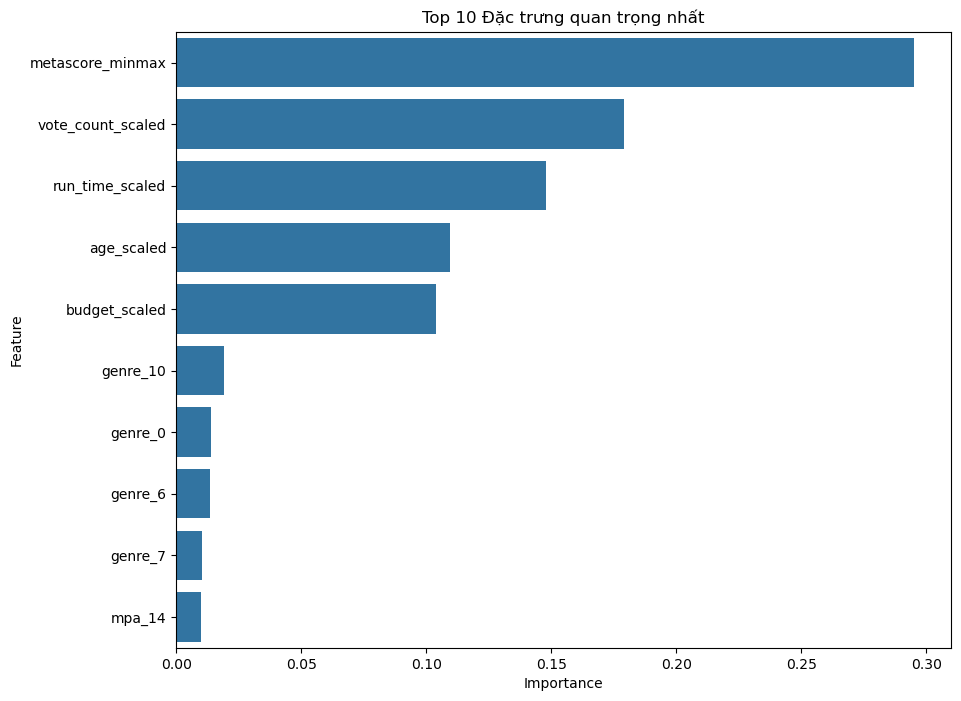

In [14]:
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Đặc trưng quan trọng nhất')
plt.show()